In [12]:
import pandas_datareader
import numpy as np
import pandas as pd
import math
import pypyodbc
import statsmodels.api as sm
from sklearn import datasets , linear_model
from statsmodels.tsa.arima.model import ARIMA
from tabulate import tabulate
from pandas_datareader import data
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf
from sympy import init_printing
init_printing()
import seaborn as sn

1A-----------------------------------------------------------------------------1A

In [13]:
#imprt data
start_date = '2010-01-01'
end_date = '2020-12-31'
lst_tickers = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

SPY = data.get_data_yahoo('SPY', start = start_date, end = end_date)
XLB = data.get_data_yahoo('XLB', start = start_date, end = end_date)
XLE = data.get_data_yahoo('XLE', start = start_date, end = end_date)
XLF = data.get_data_yahoo('XLF', start = start_date, end = end_date)
XLI = data.get_data_yahoo('XLI', start = start_date, end = end_date)
XLK = data.get_data_yahoo('XLK', start = start_date, end = end_date)
XLP = data.get_data_yahoo('XLP', start = start_date, end = end_date)
XLU = data.get_data_yahoo('XLU', start = start_date, end = end_date)
XLV = data.get_data_yahoo('XLV', start = start_date, end = end_date)
XLY = data.get_data_yahoo('XLY', start = start_date, end = end_date)
lst_dataFrames = [SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY]
print(SPY)
#XLY.join(XLV, lsuffix='_Date', rsuffix='_Date')
#XLY.set_index('Date').join(XLV.set_index('Date'))

                  High         Low        Open       Close       Volume  \
Date                                                                      
2010-01-04  113.389999  111.510002  112.370003  113.330002  118944600.0   
2010-01-05  113.680000  112.849998  113.260002  113.629997  111579900.0   
2010-01-06  113.989998  113.430000  113.519997  113.709999  116074400.0   
2010-01-07  114.330002  113.180000  113.500000  114.190002  131091100.0   
2010-01-08  114.620003  113.660004  113.889999  114.570000  126402800.0   
...                ...         ...         ...         ...          ...   
2020-12-24  369.029999  367.450012  368.079987  369.000000   26457900.0   
2020-12-28  372.589996  371.070007  371.739990  372.170013   39000400.0   
2020-12-29  374.000000  370.829987  373.809998  371.459991   53680500.0   
2020-12-30  373.100006  371.570007  372.339996  371.989990   49455300.0   
2020-12-31  374.660004  371.230011  371.779999  373.880005   78520700.0   

             Adj Close  

In [29]:
#collects the data and puts it into a dataframe that we can use
def data_collection_clean(lst_tickers, lst_dataFrames):
    df_master = SPY
    #df_master = drop(columns=['High', 'Low', 'Open', 'Close', 'Volume','Adj Close'], inplace = True)
    for i in range(len(lst_tickers)):
        df = lst_dataFrames[i]
        df.rename(columns={"Adj Close": lst_tickers[i]}, inplace = True)
        df = df[[lst_tickers[i]]]
        df_master = pd.concat([df_master, df], axis =1)
    return df_master

In [31]:
# Runs the colletion function and pseudo tests it for errors
df = data_collection_clean(lst_tickers, lst_dataFrames)
print(df)
df.drop(columns=['High', 'Low', 'Open', 'Close', 'Volume'], axis = 1, inplace = True)
daily_returns = df.pct_change()

# tests data frame for stock splits
(daily_returns >= 0.5).any()
(daily_returns <= -0.5).any()
daily_returns.isnull().sum()
df.isnull().sum()

                  High         Low        Open       Close       Volume  \
Date                                                                      
2010-01-04  113.389999  111.510002  112.370003  113.330002  118944600.0   
2010-01-05  113.680000  112.849998  113.260002  113.629997  111579900.0   
2010-01-06  113.989998  113.430000  113.519997  113.709999  116074400.0   
2010-01-07  114.330002  113.180000  113.500000  114.190002  131091100.0   
2010-01-08  114.620003  113.660004  113.889999  114.570000  126402800.0   
...                ...         ...         ...         ...          ...   
2020-12-24  369.029999  367.450012  368.079987  369.000000   26457900.0   
2020-12-28  372.589996  371.070007  371.739990  372.170013   39000400.0   
2020-12-29  374.000000  370.829987  373.809998  371.459991   53680500.0   
2020-12-30  373.100006  371.570007  372.339996  371.989990   49455300.0   
2020-12-31  374.660004  371.230011  371.779999  373.880005   78520700.0   

                   SPY  

SPY    0
SPY    0
XLB    0
XLE    0
XLF    0
XLI    0
XLK    0
XLP    0
XLU    0
XLV    0
XLY    0
dtype: int64

1B----------------------------------------------------------------------------------------------1B

In [18]:
def annualized_returns(df):
    returns=[]
    #print(df.tail())
    for column in df:
        tic = df[column]
        start = tic.head(2).iloc[0]
        end = tic.tail(1).iloc[0]
        #print(tic.tail(5))
        #print(start)
        #print(end)
        
        returns_1 = ((1+(end-start)/start)**0.1)-1     #if there is a negative return, python will return NaN so be careful
        #returns += [(((end-start)/start)**0.1)-1]
        #print((((end-start)/start)**0.1)-1)
        
        returns += [[returns_1]]
    return returns

In [19]:
# annualized returns
df_rtn = annualized_returns(df)
df_rtn = pd.DataFrame(df_rtn, index=lst_tickers,columns=['ann. rtn'])
df_rtn
print(tabulate(df_rtn, headers=['Ticker','Ann. Return'], tablefmt='github'))

ValueError: Shape of passed values is (11, 1), indices imply (10, 1)

In [419]:
# standard deviations
stdev_df = pd.DataFrame(daily_returns.std(), index=lst_tickers,columns=['stdev'])
print(tabulate(stdev_df, headers=['Ticker','Std. Dev'], tablefmt='github'))

| Ticker   |   Std. Dev |
|----------|------------|
| SPY      | 0.0108697  |
| XLB      | 0.0136095  |
| XLE      | 0.0173285  |
| XLF      | 0.0146304  |
| XLI      | 0.0128065  |
| XLK      | 0.0127541  |
| XLP      | 0.00883046 |
| XLU      | 0.0110888  |
| XLV      | 0.0106323  |
| XLY      | 0.0116774  |


1C---------------------------------------------------------------------------------------------------------------------------1C

                                  Daily Returns Covariance Matrix


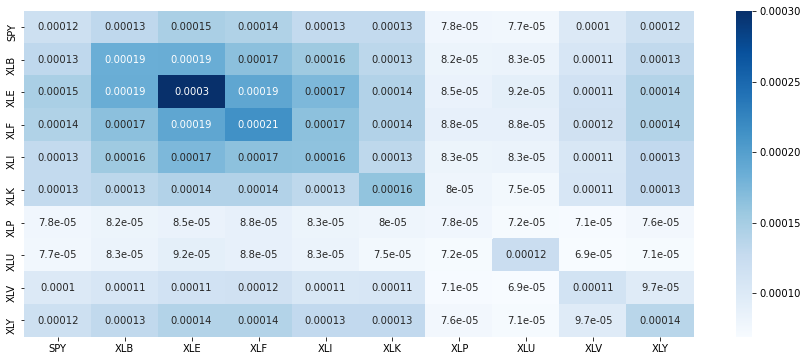

In [420]:
# covariance matirx
print('                                  Daily Returns Covariance Matrix')
daily_returns.cov()
#plt.show()
#corrMatrix1 = corr_df_rtn.corr()
plt.figure(figsize = (15,6))
sn.heatmap(daily_returns.cov(), cmap="Blues", annot=True)
plt.show()

                                  Daily Returns Corrolation Matrix


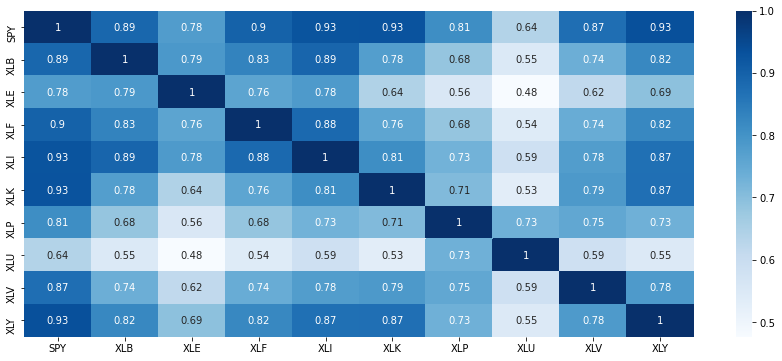

In [421]:
# covariance matirx
print('                                  Daily Returns Corrolation Matrix')
daily_returns.corr()
plt.figure(figsize = (15,6))
sn.heatmap(daily_returns.corr(), cmap="Blues", annot=True)
plt.show()

                               Montly returns covarianlce matrix


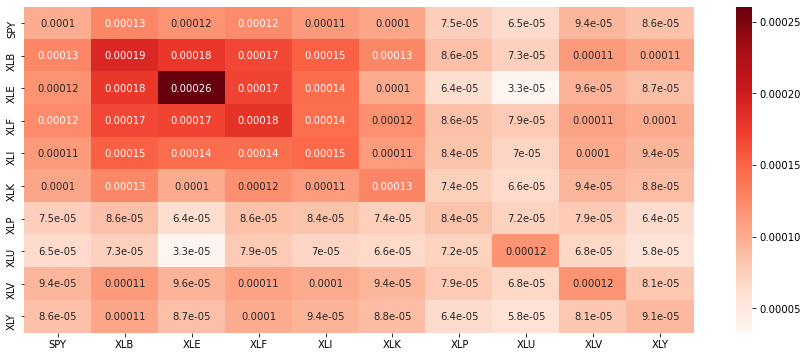

In [422]:
#monthly returns covariance matrix
monthly = daily_returns.asfreq('M').ffill()
#monthly = df.asfreq('M').ffill()
monthly[:132]
monthly = monthly.dropna()
print('                               Montly returns covarianlce matrix')
plt.figure(figsize = (15,6))
sn.heatmap(monthly.cov(), cmap="Reds", annot=True)
plt.show()

                               Montly returns corroltion matrix


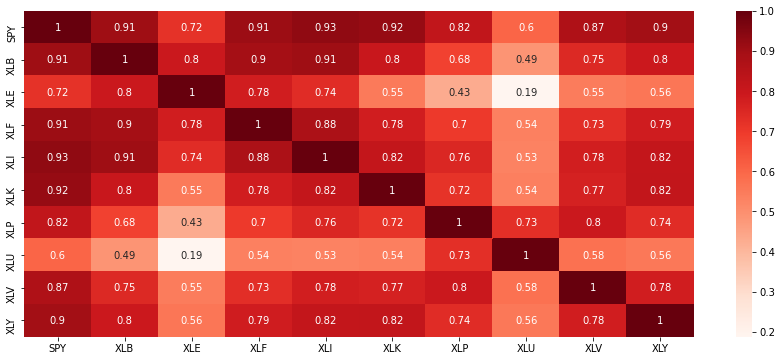

In [423]:
#monthly returns corrolation matrix

print('                               Montly returns corroltion matrix')
#sn.palplot(sn.diverging_palette(10, 220, sep=80, n=7))
#cmap = sn.diverging_palette(133, 10, as_cmap=True)
plt.figure(figsize = (15,6))
sn.heatmap(monthly.corr(), cmap="Reds", annot=True)
plt.show()

1D--------------------------------------------------------------------------------------------1D

In [424]:
# rolling corrolations 
def rolling_ninty_day(df):
    spy_rolling_corr = df['SPY'].rolling(90).corr(df['SPY'])
    spy_rolling_corr = spy_rolling_corr.dropna()
    index_rolling = spy_rolling_corr.index
    df_90 = pd.DataFrame(spy_rolling_corr, index_rolling)
    
    for i in range(1, df.shape[1]):
        ETF = df.iloc[: , i]
        etf_rolling_corr = df['SPY'].rolling(90).corr(ETF)
        etf_rolling_corr = etf_rolling_corr.dropna()
        index_rolling = etf_rolling_corr.index
        df_90 = pd.concat([df_90, etf_rolling_corr], axis =1)
    return df_90

                              Rolling 90-day Corrolation Time Series


<Figure size 1296x576 with 0 Axes>

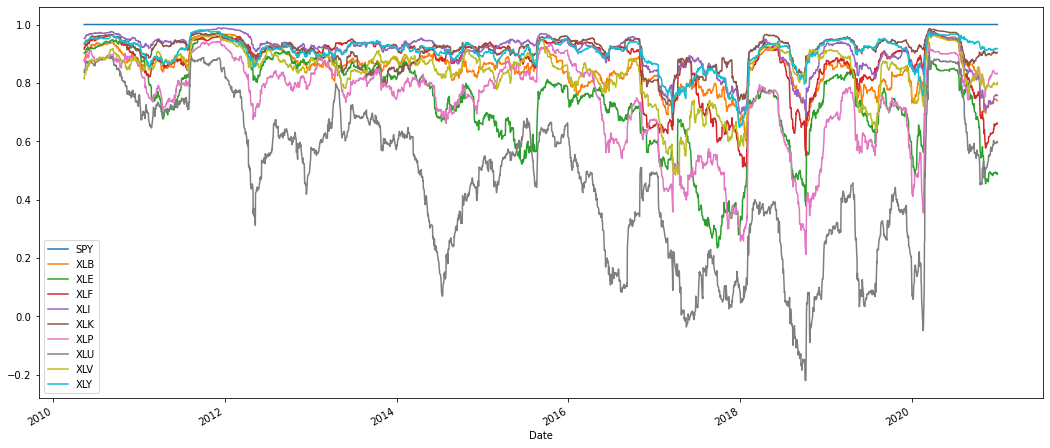

In [425]:
rolling_df = rolling_ninty_day(daily_returns)
#print(rolling_df)
rolling_df.columns = lst_tickers
print('                              Rolling 90-day Corrolation Time Series')
plt.figure(figsize = (18,8))
rolling_df.plot(figsize = (18,8))
plt.show()

1E----------------------------------------------------------------------------------------1E

In [426]:
# hackey beta, easy to work with(no regression)
# betas for part (E)
def custom_betas(x_name, window, returns_data):
    window_inv = 1.0 / window
    x_sum = returns_data[x_name].rolling(window, min_periods=window).sum()
    y_sum = returns_data.rolling(window, min_periods=window).sum()
    xy_sum = returns_data.mul(returns_data[x_name], axis=0).rolling(window, min_periods=window).sum()
    xx_sum = np.square(returns_data[x_name]).rolling(window, min_periods=window).sum()
    xy_cov = xy_sum - window_inv * y_sum.mul(x_sum, axis=0)
    x_var = xx_sum - window_inv * np.square(x_sum)
    betas = xy_cov.divide(x_var, axis=0)[window - 1:]
    betas.columns.name = None
    return betas

| Ticker   |   Sample reg. Alphas |
|----------|----------------------|
| SPY      |              0.00000 |
| XLB      |             -0.00018 |
| XLE      |             -0.00059 |
| XLF      |             -0.00018 |
| XLI      |             -0.00005 |
| XLK      |              0.00015 |
| XLP      |              0.00011 |
| XLU      |              0.00009 |
| XLV      |              0.00010 |
| XLY      |              0.00016 |

| Ticker   |   Sample Betas |
|----------|----------------|
| SPY      |       1        |
| XLB      |       1.11245  |
| XLE      |       1.24383  |
| XLF      |       1.21027  |
| XLI      |       1.09357  |
| XLK      |       1.09135  |
| XLP      |       0.658716 |
| XLU      |       0.650757 |
| XLV      |       0.855753 |
| XLY      |       1.00408  |


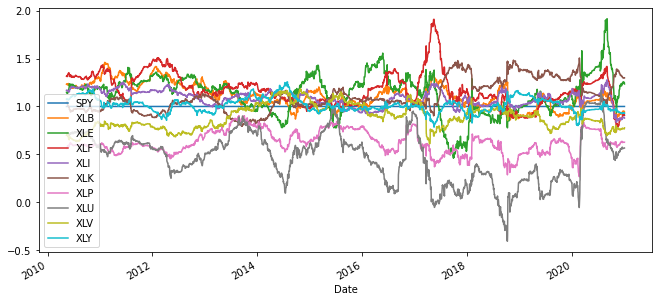

In [427]:
# betas for part (E)
dfbeta = df.pct_change()
dfbeta = dfbeta.dropna()

betas = []
alphas = []
#loop to produce sample betas
for i in range(len(lst_tickers)):
    ETF = dfbeta.iloc[: , i]
    (beta, alpha) = si.linregress(dfbeta['SPY'].values,dfbeta[lst_tickers[i]].values)[0:2]
    betas += [beta]
    alphas += [[alpha]]
    #print(f"The {lst_tickers[i]} beta is, {round(beta, 6)} \n")
    #print(f"The {lst_tickers[i]} alpha is, {round(alpha,5)} \n")
alphas = pd.DataFrame(alphas, index=lst_tickers,columns=['alphas'])
print(tabulate(alphas, headers=['Ticker','Sample reg. Alphas'], tablefmt='github', floatfmt=".5f"))
print()


# hacky way to do the rolling 90-day 
df_beta_90 = custom_betas('SPY',90, dfbeta)
#print(df_beta_90)
df_beta_90.plot(figsize = (11,5))

# print out the sample betas
df_beta_total = custom_betas('SPY',len(dfbeta.index), dfbeta)
print(tabulate(df_beta_total.T, headers=['Ticker','Sample Betas'], tablefmt='github'))

1F--------------------------------------------------------------------------------------------------1F

In [428]:
# auto corrolations in one series, part (f)
corrolations = []
df_corrolation = df.pct_change()
df_corrolation = df_corrolation.dropna()
for i in range(len(lst_tickers)):
    auto_cor = sm.tsa.acf(df_corrolation[lst_tickers[i]], nlags=1)
    #print(f' {lst_tickers[i]} :{auto_cor[1]}')
    corrolations += [auto_cor]
corrolations = pd.DataFrame(corrolations, index=lst_tickers,columns=['tickers','alphas'])
print(tabulate(corrolations.iloc[:,[1]], headers=['Ticker','Auto corrolation Alphas'], tablefmt='github', floatfmt=".4f"))

| Ticker   |   Auto corrolation Alphas |
|----------|---------------------------|
| SPY      |                   -0.1364 |
| XLB      |                   -0.0694 |
| XLE      |                   -0.0515 |
| XLF      |                   -0.1460 |
| XLI      |                   -0.0596 |
| XLK      |                   -0.1595 |
| XLP      |                   -0.1286 |
| XLU      |                   -0.1014 |
| XLV      |                   -0.1125 |
| XLY      |                   -0.0806 |


C:\Users\kuntz\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


This is the code for 2-------------------------------------------------------------This is the code for 2

In [429]:
class MCStockSimulator:

    def __init__(self, s_0, t, r, sigma, N,M,K):
        '''the constructor for Date objects
        s = current stock price
        t = option maturity 
        r = annualixed rate of return 
        sigma = annualized standard deviation of returns
        N = number of dicrete time periods
        M = number of simulations
        K = Strike price
        '''
        self.s_0 = s_0
        self.t = t
        self.r = r
        self.sigma = sigma
        self.N = N
        self.M = M
        self.K = K
        
    def __repr__(self):
        return f'StockSimulator (s=${self.s_0:8.2f}, t={self.t:8.2f} (years), r={self.r:8.2f}, sigma={self.sigma:8.2f}, nper_per_year={self.N:8.2f}'

    def generate_simulated_stock_returns(self):
        mu = self.r
        returns = []
        numsteps = int(self.t * self.N//1)
        for i in range(numsteps):
            z = np.random.normal()
            stock_return = (mu - (self.sigma ** 2) / 2) * (1 / self.N) + z * self.sigma * ((1 / self.N) ** 0.5)
            returns.append(stock_return)
        return np.array(returns)
    
    def generate_simulated_stock_values(self):
        stock_path = [self.s_0]
        returns = self.generate_simulated_stock_returns()
        numsteps = int(self.t * self.N//1)
        for i in range(numsteps):
            snext = stock_path[i] * np.exp(returns[i])
            stock_path.append(snext)
            path_series = np.array(stock_path)
        return path_series
    
    def terminal_valueS0(self,K):
        lst_s_put = []
        for i in range(self.M):
            sx_put = self.generate_simulated_stock_values()
            sp_put = sx_put[-1]
            lst_s_put.append(sp_put)
            
        self.mean = np.mean(lst_s_put)
        self.variance = np.var(lst_s_put)
        
        return lst_s_put, self.mean, self.variance
    
    def terminal_value(self,K):
        lst_sx_put = []
        for i in range(self.M):
            sx_put = self.generate_simulated_stock_values()
            sp_put = sx_put[-1]
            put_value = max(self.K - sp_put, 0) * np.exp(-self.r * self.t)
            lst_sx_put.append(put_value)
            
        self.mean = np.mean(lst_sx_put)
        self.variance = np.var(lst_sx_put)
        
        return lst_sx_put, self.mean, self.variance
    
    def path_value(self,K):
        lst_sx_put = []
        for i in range(self.M):
            sx_put = self.generate_simulated_stock_values()
            sp_put = sx_put
            put_value = max(self.K - sp_put[i], 0) * np.exp(-self.r * self.t)
            lst_sx_put.append(put_value)
            
        self.mean = np.mean(lst_sx_put)
        self.variance = np.var(lst_sx_put)
        
        return lst_sx_put #, self.mean, self.stdev
        
    def path_value_lookback(self,K):
        lst_sx_put = []
        lst_lookback = []
        for i in range(self.N):
            sx_put = self.generate_simulated_stock_values()
            sp_put = sx_put
            put_value = max(self.K - sp_put[i], 0) * np.exp(-self.r * self.t)
            lst_sx_put.append(put_value)
            lst_lookback += [max(lst_sx_put)]
        self.mean = np.mean(lst_sx_put)
        self.variance = np.var(lst_sx_put)
        lst_paths = []
        for j in range(self.M):
            #lst_lookback = [max(lst_sx_put)]
            lst_paths += [np.array(lst_lookback)]
        mean_lookback = np.mean(lst_paths)    
        return mean_lookback
    
    def plot_simulated_stock_values(self, num_trials = 1):
        '''Write the method plot_simulated_stock_values(self, num_trials = 1), 
        that will generate a plot of of num_trials series of simulated stock returns. 
        num_trials is an optional parameter; if it is not supplied, the default 
        value of 1 will be used.
        '''
        number_x = int(self.t * self.N//1)
        term_x = 1 / self.N
        x = 0
        list_for_x = [0]
        for i in range(number_x):
            x += term_x 
            list_for_x.append(x)
        for j in range(num_trials):
            list_y = self.generate_simulated_stock_values()
            plt.plot(list_for_x, list_y)
            
        plt.title(f'{num_trials} simulated trials')
        plt.xlabel('years')
        plt.ylabel('$ value')
        
        return plt.show()
    
    def path_list(self):
        lst_paths = []
        for i in range(self.M):
            lst_paths += [np.array(self.path_value(self.K))]
            #print(lst_paths)
        return lst_paths
    
    def look_back_put(self):
        lst_paths = []
        for i in range(self.M):
            lst_paths += [np.array(self.path_value_lookback(self.K))]
            #print(lst_paths)
        mean = np.mean(lst_paths)
        return mean
    
    def euro_put(self, s_0, K, T, r, sigma):
        #S: spot price
        #K: strike price
        #T: time to maturity
        #r: interest rate
        #sigma: volatility of underlying asset
    
        d1 = (np.log(s_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(s_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
        put = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - s_0 * si.norm.cdf(-d1, 0.0, 1.0))
    
        return put
    

In [448]:
sim = MCStockSimulator(100, 1, 0.0, 0.25, 253,10000,100)
#sim.plot_simulated_stock_values(5)

In [449]:
print('THIS IS PART A**********************************************************')
terminals_S0 = sim.terminal_valueS0(100)
#plt.plot(terminals[0])
#plt.show   
#print(terminals)
print(f'The mean of the payoffs is: {terminals_S0[1]:8.4f}')
print(f'The variance of the payoffs is: {terminals_S0[2]:8.4f}')



THIS IS PART A**********************************************************
The mean of the payoffs is:  99.9841
The variance of the payoffs is: 656.0744


THIS IS PART B**********************************************************

The mean of the payoffs is:   9.9678
The variance of the payoffs is: 158.9619


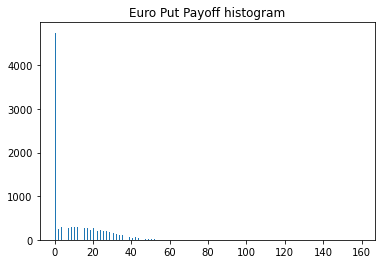

In [450]:
print('THIS IS PART B**********************************************************')
print()
terminals = sim.terminal_value(100)
#plt.plot(terminals[0])
#plt.show   
#print(terminals)
print(f'The mean of the payoffs is: {terminals[1]:8.4f}')
print(f'The variance of the payoffs is: {terminals[2]:8.4f}')
histogram = plt.hist(terminals, bins = 'auto')
plt.title('Euro Put Payoff histogram')
plt.show()



In [451]:
print('THIS IS PART C ****************************************************************************')
terminals1 = sim.terminal_value(100)
print(f'The mean of the payoffs is: {terminals1[1]:8.4f}')



THIS IS PART C ****************************************************************************
The mean of the payoffs is:  10.0190


In [452]:
print('THIS IS PART D**********************************************************')
terminals = sim.terminal_value(100)
print(f'The mean of the payoffs is: {terminals[1]:8.4f}')
BS_premium = sim.euro_put(100, 100, 1, 0.0, 0.25)
print(f'The BS premium is : {BS_premium}')



THIS IS PART D**********************************************************
The mean of the payoffs is:   9.9587
The BS premium is : 9.94764496602258


In [453]:
print('THIS IS PART E**********************************************************')
lookback_payoff = sim.path_value_lookback(100)
print(f'The value of the look-back payoff is: {lookback_payoff}')

#lookback_payoff = sim.look_back_put()
#print(lookback_payoff)


THIS IS PART E**********************************************************
The value of the look-back payoff is: 29.641234150103653


In [454]:
print('THIS IS PART F**********************************************************')
#terminals = sim.terminal_value(100)
euro_payoff = terminals[1]
premium_difference = lookback_payoff - euro_payoff
print(f' the premium difference is: {premium_difference}')


THIS IS PART F**********************************************************
 the premium difference is: 19.682559197136527


In [437]:
print('THIS IS PART G**********************************************************')
sim1 = MCStockSimulator(100, 1, 0.0, 0.225, 253,1000,100)
print('SIM1')
lookback_payoff = sim1.path_value_lookback(100)
print(lookback_payoff)
terminals = sim1.terminal_value(100)
euro_payoff = terminals[1]
premium_difference = lookback_payoff - euro_payoff
print(f' the premium difference is: {premium_difference}')
print()

sim2 = MCStockSimulator(100, 1, 0.0, 0.275, 253,1000,100)
print('SIM2')
lookback_payoff = sim2.path_value_lookback(100)
print(lookback_payoff)
terminals = sim2.terminal_value(100)
euro_payoff = terminals[1]
premium_difference = lookback_payoff - euro_payoff
print(f' the premium difference is: {premium_difference}')
print()

sim3 = MCStockSimulator(100, 1, 0.0, 0.19, 253,1000,100)
print('SIM3')
lookback_payoff = sim3.path_value_lookback(100)
print(lookback_payoff)
terminals = sim3.terminal_value(100)
euro_payoff = terminals[1]
premium_difference = lookback_payoff - euro_payoff
print(f' the premium difference is: {premium_difference}')
print()

sim4 = MCStockSimulator(100, 1, 0.0, 0.17, 253,1000,100)
print('SIM4')
lookback_payoff = sim4.path_value_lookback(100)
print(lookback_payoff)
terminals = sim4.terminal_value(100)
euro_payoff = terminals[1]
premium_difference = lookback_payoff - euro_payoff
print(f' the premium difference is: {premium_difference}')
print()

sim5 = MCStockSimulator(100, 1, 0.0, 0.12, 253,1000,100)
print('SIM5')
lookback_payoff = sim5.path_value_lookback(100)
print(lookback_payoff)
terminals = sim4.terminal_value(100)
euro_payoff = terminals[1]
premium_difference = lookback_payoff - euro_payoff
print(f' the premium difference is: {premium_difference}')
print()

THIS IS PART G**********************************************************
SIM1
25.258332477121364
 the premium difference is: 16.839366844957915

SIM2
34.238833732777685
 the premium difference is: 22.446996233217583

SIM3
24.17413916360142
 the premium difference is: 16.806253843688218

SIM4
19.953859229335134
 the premium difference is: 13.230786549331079

SIM5
14.626436412718567
 the premium difference is: 7.824911908455785



In [ ]:
def lookbackput_fixed(S_0, K, T, r, sigma, N, M):
    
    S = sp.random.rand(N+1)
    sumpayoff = 0.0
    premium = 0.0
    dt = T/N
    
    # STEP 2: MAIN SIMULATION LOOP
    for j in range(M):
   	
        S[0]=S_0

        # STEP 3: TIME INTEGRATION LOOP
        for i in range(N):
        
            epsilon =  sp.random.randn(1)
            S[i+1] = S[i]*(1+r*dt+sigma*math.sqrt(dt)*epsilon)
        
        # STEP 4: COMPUTE PAYOFF
        Smin = min(S)
        sumpayoff += max(0, K-Smin)*np.exp(-r*T)
        
    # STEP 5: COMPUTE DISCOUNTED EXPECTED PAYOFF
    premium =  math.exp(-r*T)*(sumpayoff / M) 
    
    
    return premium

In [388]:
print(lookbackput_fixed(100, 100, 1, 0, 0.25,253,10000))

17.753982876892028


In [389]:
print(lookbackput_fixed(100, 100, 1, 0, 0.25,253,10000))

17.75910463230636


In [390]:
print(lookbackput_fixed(100, 100, 1, 0, 0.25,253,10000))

17.726939819390346


In [391]:
print(lookbackput_fixed(100, 100, 1, 0, 0.25,253,10000))

17.764211505477526


In [392]:
print(lookbackput_fixed(100, 100, 1, 0, 0.25,253,10000))

17.918185122771533


In [393]:
print(lookbackput_fixed(100, 100, 1, 0, 0.25,253,10000))

17.68841440003673
